In [154]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# Define Sampling layer as a subclass of keras.layers.Layer
## Sampling layer: Layer that samples a random point in latent space from a distribution with a mean and variance

In [155]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Define latent space dimension

In [156]:
latent_dim = 2

# Encoder

In [157]:

encoder_inputs = keras.Input(shape=(6000,1))

x = layers.Conv1D(256,16,strides=2,padding='same',activation='relu',use_bias=True,kernel_initializer='VarianceScaling',bias_initializer = 'Zeros')(encoder_inputs)#possibly update kernel_initializer
#x = layers.MaxPooling1D(pool_size = 4,strides = 4, padding = 'same')(x)

x = layers.Conv1D(128,8,strides=2,padding='same',activation='relu',use_bias=True,kernel_initializer='VarianceScaling',bias_initializer = 'Zeros')(x)#possibly update kernel_initializer
#x = layers.MaxPooling1D(pool_size = 4,strides = 4, padding = 'same')(x)

x = layers.Conv1D(32,8,strides=2,padding='same',activation='relu',use_bias=True,kernel_initializer='VarianceScaling',bias_initializer = 'Zeros')(x)#possibly update kernel_initializer
#x = layers.MaxPooling1D(pool_size = 4,strides = 4, padding = 'same')(x)

shape_before_flattening = K.int_shape(x)

flatten_1 = layers.Flatten()(x)
x = layers.Dense(16 , activation="relu")(flatten_1)

z_mean = layers.Dense(latent_dim, name="z_mean",kernel_initializer='Zeros',bias_initializer = 'Zeros')(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var",kernel_initializer='Zeros',bias_initializer = 'Zeros')(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 6000, 1)]    0           []                               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 3000, 256)    4352        ['input_9[0][0]']                
                                                                                                  
 conv1d_13 (Conv1D)             (None, 1500, 128)    262272      ['conv1d_12[0][0]']              
                                                                                                  
 conv1d_14 (Conv1D)             (None, 750, 32)      32800       ['conv1d_13[0][0]']              
                                                                                            

# Decoder

In [158]:

#DECODER
latent_inputs = keras.Input(shape=(latent_dim,))

# x = layers.Dense(1500, activation="relu")(latent_inputs)

#x = layers.Dense(1500, activation="relu")(latent_inputs)

x = layers.Dense(np.prod(shape_before_flattening[1:]), activation="relu")(latent_inputs)
x = layers.Reshape(shape_before_flattening[1:])(x)

x = layers.Conv1DTranspose(32, 8, activation="relu", strides=2, padding="same")(x)
x = layers.Conv1DTranspose(128, 8, activation="relu", strides=2, padding="same")(x)
x = layers.Conv1DTranspose(256, 16, activation="relu", strides=2, padding="same")(x)


decoder_outputs = layers.Conv1DTranspose(1, 16, padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_9 (Dense)             (None, 24000)             72000     
                                                                 
 reshape_4 (Reshape)         (None, 750, 32)           0         
                                                                 
 conv1d_transpose_16 (Conv1D  (None, 1500, 32)         8224      
 Transpose)                                                      
                                                                 
 conv1d_transpose_17 (Conv1D  (None, 3000, 128)        32896     
 Transpose)                                                      
                                                                 
 conv1d_transpose_18 (Conv1D  (None, 6000, 256)        5245

# Defining subclass VAE
## VAE is a subclass of keras.Model class

In [159]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),axis=(1)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=0))
            total_loss = reconstruction_loss + kl_loss
            #total_loss = reconstruction_loss #ABSOLUTELY CHANGE!
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Load dataset
## And convert it to numpy array

In [160]:

train_X = pd.read_csv('/home/ege/Repo/SideChannel-AdversarialAI/Tensorflow/DataSet/trainX13.csv', header=None)
train_Y = pd.read_csv('/home/ege/Repo/SideChannel-AdversarialAI/Tensorflow/DataSet/trainY13.csv', header=None)

trainY = train_Y.to_numpy()
trainX = train_X.to_numpy()
trainX = np.expand_dims(trainX,axis=2)

# Normalize dataset

In [185]:
minimum = np.amin(trainX)
maximum = np.amax(trainX)

trainX = (trainX-minimum)/(maximum-minimum)

classToCut = 6

trainXCUT = trainX[classToCut::14]
trainYCUT = trainY[classToCut::14]

# Train model

In [186]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(trainXCUT, epochs=25, batch_size=32)

Epoch 1/25
4/4 [==============================] - 3s 34ms/step - loss: 1304.4173 - reconstruction_loss: 1279.1912 - kl_loss: 5.1053
Epoch 2/25
4/4 [==============================] - 0s 31ms/step - loss: 1307.3676 - reconstruction_loss: 1287.2382 - kl_loss: 4.1569
Epoch 3/25
4/4 [==============================] - 0s 31ms/step - loss: 1303.0650 - reconstruction_loss: 1281.3887 - kl_loss: 3.3700
Epoch 4/25
4/4 [==============================] - 0s 31ms/step - loss: 1282.5999 - reconstruction_loss: 1284.2971 - kl_loss: 3.4335
Epoch 5/25
4/4 [==============================] - 0s 31ms/step - loss: 1280.1322 - reconstruction_loss: 1284.5995 - kl_loss: 3.8305
Epoch 6/25
4/4 [==============================] - 0s 31ms/step - loss: 1266.3373 - reconstruction_loss: 1292.5684 - kl_loss: 4.6636
Epoch 7/25
4/4 [==============================] - 0s 31ms/step - loss: 1273.7571 - reconstruction_loss: 1287.1609 - kl_loss: 5.0138
Epoch 8/25
4/4 [==============================] - 0s 31ms/step - loss: 1290.

# Load classification model

In [187]:
classification_model = tf.keras.models.load_model('TrainedModel/trainedModel.h5')

# Test reconstructed dataset with the classification model

In [188]:

for i in range(14):
    

    trainXCUT = trainX[i::14]
    trainYCUT = trainY[i::14]

    z_mean, z_log_var, z = vae.encoder.predict(trainXCUT)
    reconstructed_x = vae.decoder.predict(z)
    
    classification_model.evaluate((reconstructed_x),trainYCUT)
    

4/4 [==============================] - 0s 3ms/step - loss: 12.0647 - accuracy: 0.0000e+00


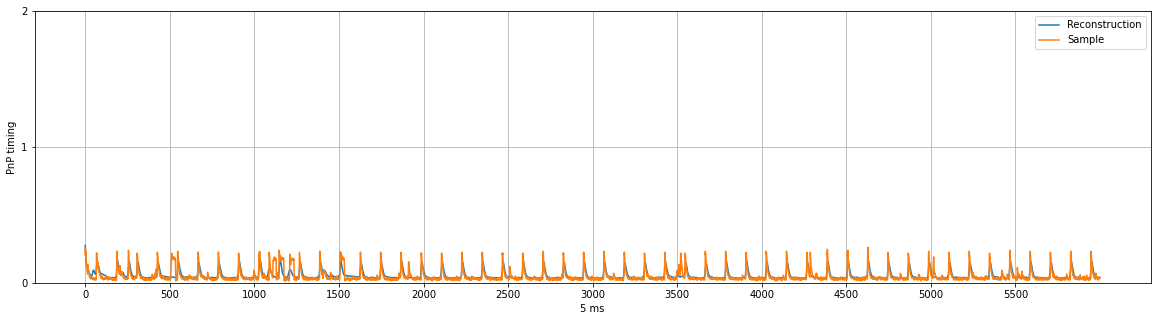

In [192]:

trainXCUT = trainX[classToCut::14]
trainYCUT = trainY[classToCut::14]

z_mean, z_log_var, z = vae.encoder.predict(trainXCUT)
reconstructed_x = vae.decoder.predict(z)*(maximum-minimum)+minimum

fig = plt.figure(figsize=(20,5))
#plt.plot(results)

sampleToPredict = 17

plt.plot(reconstructed_x[sampleToPredict],label='Reconstruction')
plt.plot(trainXCUT[sampleToPredict]*(maximum-minimum)+minimum,label='Sample')
#plt.plot(data3[0],label=3)
#plt.plot(data4[0],label=4)
#plt.plot(averageArray[0])

plt.legend()
plt.yticks(np.arange(0, 3, 1))
plt.xticks(np.arange(0, 6000, 500))
plt.grid()
#plt.axhline(linewidth=1, color='r')
plt.xlabel("5 ms")
plt.ylabel("PnP timing")
#figure(figsize=(8, 6), dpi=80)
fig.savefig('vis_test.png',dpi=200)